In [1]:
import scanpy as sc
import scvelo as scv
import cellrank as cr
from velovi import preprocess_data, VELOVI
import torch
import numpy as np

Import data

In [2]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scCFM/data/pancreas/rawdata/adata_pancreas_2019.h5ad")

In [3]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)

Filtered out 6787 genes that are detected 30 counts (shared).
Normalized count data: spliced, unspliced.


/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See http

Extracted 2000 highly variable genes.
Logarithmized X.


/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


Compute PCA and moments

In [4]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Plot scatter 

In [5]:
adata = preprocess_data(adata)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [6]:
adata.uns["celltype_colors"]=['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b',
        '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#ffbb78', '#98df8a',
        '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#dbdb8d']

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


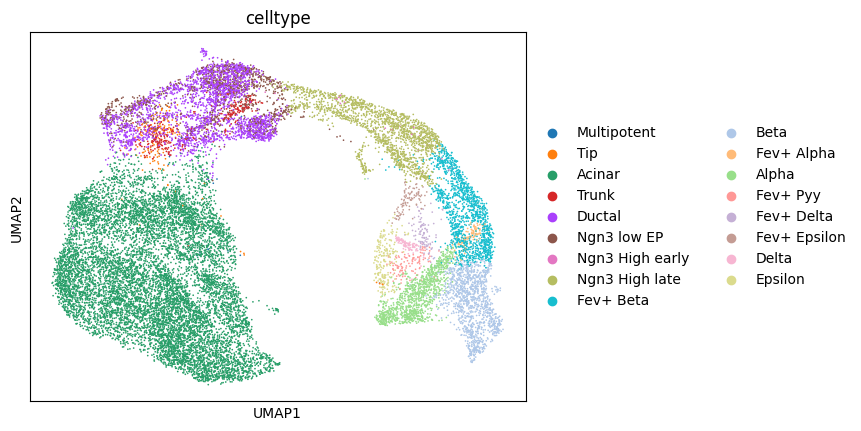

In [9]:
sc.pl.umap(adata, color="celltype")

**Run velocity estimation**

In [10]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/scCFM/lib ...
  rank_zero_warn(
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/scCFM/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/alessandro.palma/miniconda3/

Epoch 313/500:  63%|██████▎   | 313/500 [06:06<03:39,  1.17s/it, v_num=1, train_loss_step=-4.45e+3, train_loss_epoch=-4.79e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -4722.141. Signaling Trainer to stop.


In [11]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

In [12]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/112 cores)


  0%|          | 0/20519 [00:00<?, ?cells/s]

    finished (0:01:52) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:04) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


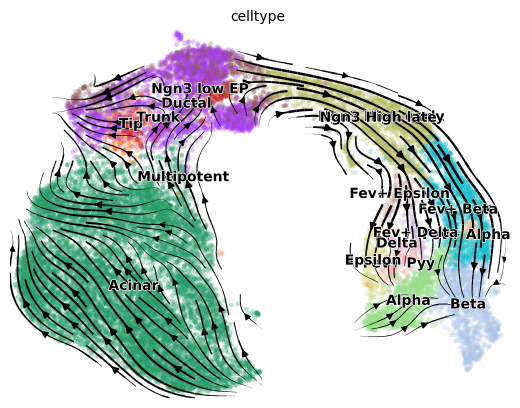

In [13]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color="celltype")

## Run cellrank

In [14]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()

  0%|          | 0/20519 [00:00<?, ?cell/s]

  0%|          | 0/20519 [00:00<?, ?cell/s]

VelocityKernel[n=20519, model='deterministic', similarity='correlation', softmax_scale=22.413]

In [15]:
ck = cr.kernels.ConnectivityKernel(adata)
ck.compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck

In [16]:
adata

AnnData object with n_obs × n_vars = 20519 × 1335
    obs: 'day', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'proliferation', 'G2M_score', 'S_score', 'clusters_fig3_final', 'clusters_fig3_final_noep', 'clusters_fig4_final', 'clusters_fig2_final', 'clusters_fig6_broad_final', 'clusters_fig6_fine_final', 'clusters_fig6_alpha_final', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'velocity_self_transition'
    var: 'n_cells', 'highly_variable_genes', 'expression_mean', 'dispersion', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
    uns: 'clusters_fig6_fine_final_colors', 'log1p', 'pca', 'neighbors', 'velocity_params', 'celltype_colors', '_scvi_uuid', '_scvi_manager_uuid', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced

In [17]:
g_vae = cr.estimators.GPCCA(vk)
g_vae.fit(n_states=15, cluster_key="celltype")

GPCCA[kernel=VelocityKernel[n=20519], initial_states=None, terminal_states=None]

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


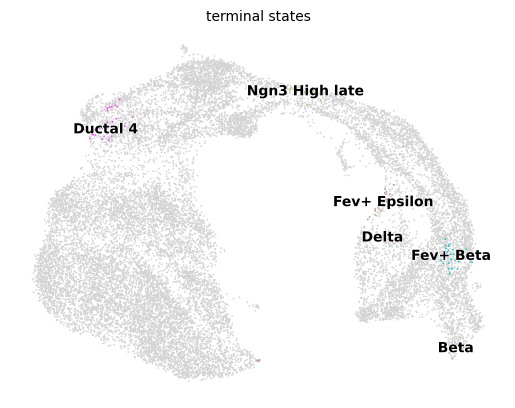

In [18]:
g_vae.predict_terminal_states(method="top_n", n_states=6)
g_vae.plot_macrostates(which="terminal")

In [19]:
scv.tl.velocity_confidence(adata)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


In [20]:
np.mean(adata.obs["velocity_confidence"])

0.9239094460084312